In [ ]:
# importing required libraries/packages
import gc
from spectral import envi
import numpy as np
# from pysptools.noise import SavitzkyGolay
import os
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##The input HSI cube, corresponding white and dark images are loaded.The HSIs were taken during a neurosurgical procedure.

In [ ]:
# Setting paths
input_hsi_cube_path = '/content/drive/My Drive/Colab_Files/012-01'
hdr_path = os.path.join(input_hsi_cube_path, "raw.hdr")
raw_path = os.path.join(input_hsi_cube_path, "raw")
white_ref_path = os.path.join(input_hsi_cube_path, "whiteReference.hdr")
dark_ref_path = os.path.join(input_hsi_cube_path, "darkReference.hdr")

h = envi.read_envi_header(hdr_path)
wavelengths = [float(x) for x in h['wavelength']]
raw_data = envi.open(hdr_path, raw_path)
white_data = envi.open(white_ref_path, white_ref_path.replace(".hdr", ""))
dark_data = envi.open(dark_ref_path, dark_ref_path.replace(".hdr", ""))

# loading raw data, white and dark tiles as numpy arrays
raw = np.array(raw_data.load())
white = np.array(white_data.load())
dark = np.array(dark_data.load())

print("The path of the input HSI cube: ", input_hsi_cube_path)
print("Patient ID:", input_hsi_cube_path.split("Colab_Files/")[1])
print("Shape of the input HSI cube", raw.shape)
print("Shape of the white tile", white.shape)
print("Shape of the dark tile", dark.shape)

The path of the input HSI cube:  /content/drive/My Drive/Colab_Files/012-01
Patient ID: 012-01
Shape of the input HSI cube (443, 497, 826)
Shape of the white tile (1, 497, 826)
Shape of the dark tile (1, 497, 826)


## The input HSI cube has 826 bands. Among those, some bands are visualized.

Size of band 0 is: (443, 497) minimum value: 8.0 maximum value: 117.0
Size of band 50 is: (443, 497) minimum value: 8.0 maximum value: 1132.0
Size of band 100 is: (443, 497) minimum value: 13.0 maximum value: 3485.0
Size of band 200 is: (443, 497) minimum value: 13.0 maximum value: 4095.0
Size of band 300 is: (443, 497) minimum value: 20.0 maximum value: 4095.0
Size of band 400 is: (443, 497) minimum value: 22.0 maximum value: 4095.0
Size of band 500 is: (443, 497) minimum value: 22.0 maximum value: 3278.0
Size of band 600 is: (443, 497) minimum value: 19.0 maximum value: 1176.0
Size of band 700 is: (443, 497) minimum value: 15.0 maximum value: 442.0
Size of band 825 is: (443, 497) minimum value: 11.0 maximum value: 78.0


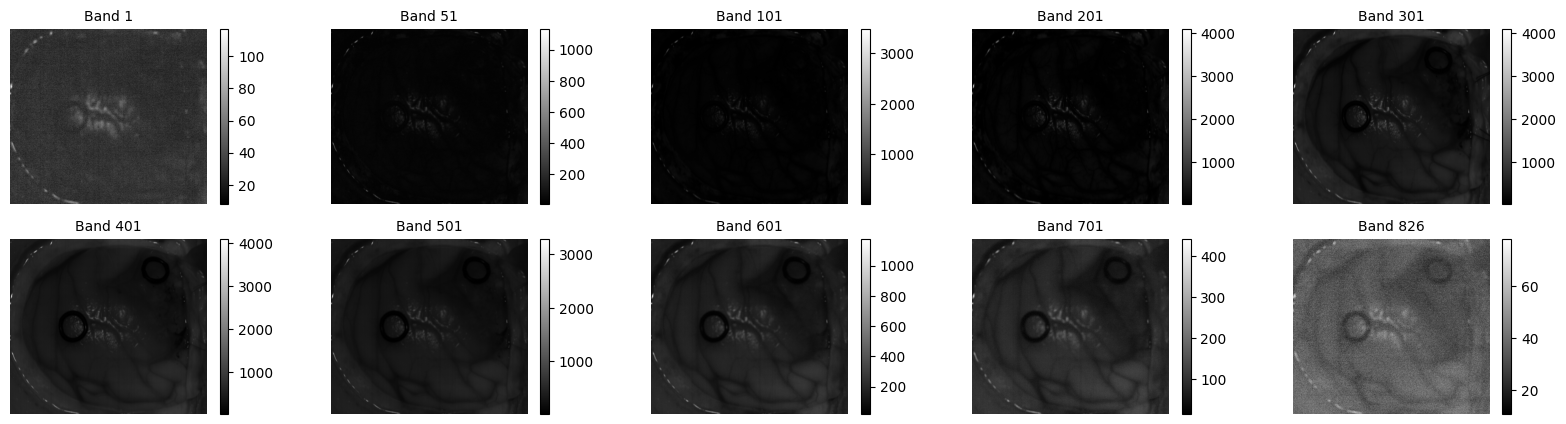

In [ ]:
#Visualizing some random bands
band_indices = [0, 50, 100, 200, 300, 400, 500, 600, 700, 825]  # Change the numbers(within 0 to 825) of this list based on the bands you want to visualize.

plt.figure(figsize=(20,5))

for i, band_index in enumerate(band_indices):
    plt.subplot(2, len(band_indices)//2, i+1)
    selected_band = raw[:,:,band_index]
    plt.imshow(selected_band, cmap='gray'), plt.title(f"Band {band_index+1}", fontsize=10)
    plt.colorbar()
    plt.axis('off')
    print(f"Size of band {band_index} is:", selected_band.shape, "minimum value:", np.min(selected_band), "maximum value:", np.max(selected_band))

## Next, calibration is performed following this formula : calibrated_cube = (raw - dark) / (white - dark). The changes are not much obvious through visual inspection, but the minimum and maximum values of the bands changed.

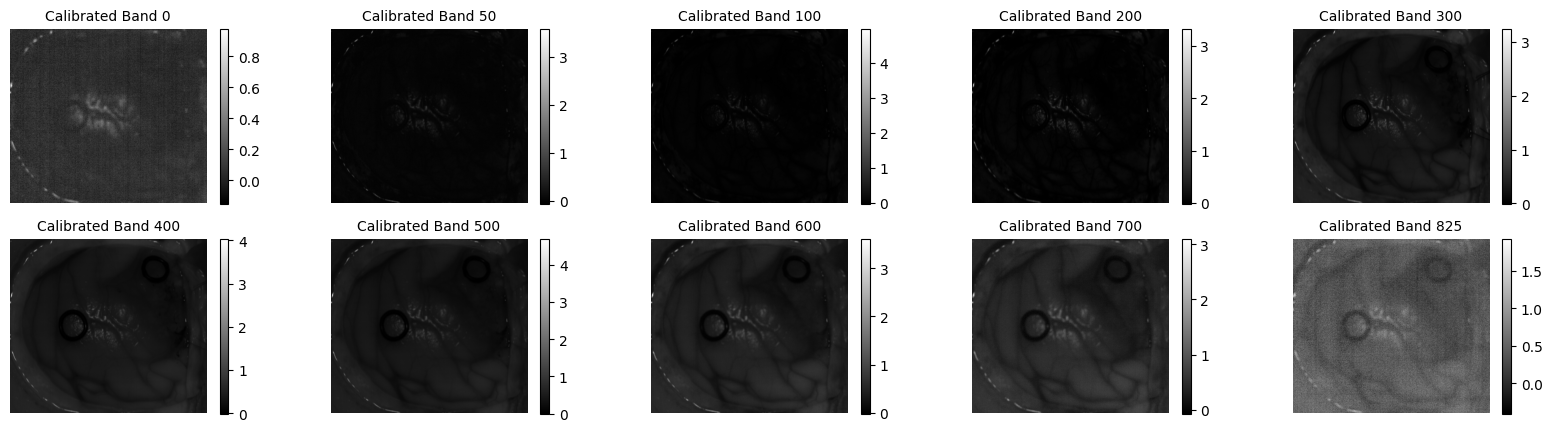

In [ ]:
# Image calibration
calibrated_raw = np.divide(np.subtract(raw, dark), np.subtract(white, dark))

plt.figure(figsize=(20,5))

for i, band_index in enumerate(band_indices):
    plt.subplot(2, len(band_indices)//2, i+1)
    selected_band = calibrated_raw[:,:,band_index]
    plt.imshow(selected_band, cmap='gray'), plt.title(f"Calibrated Band {band_index}", fontsize=10)
    plt.colorbar()
    plt.axis('off')
    # print(f"Size of band {band_index} is:", selected_band.shape, "minimum value:", np.min(selected_band), "maximum value:", np.max(selected_band))

## Movign average filter is applied on the calibrated HSI cube in the spectral dimension. The resulting bands show comparatively better results.

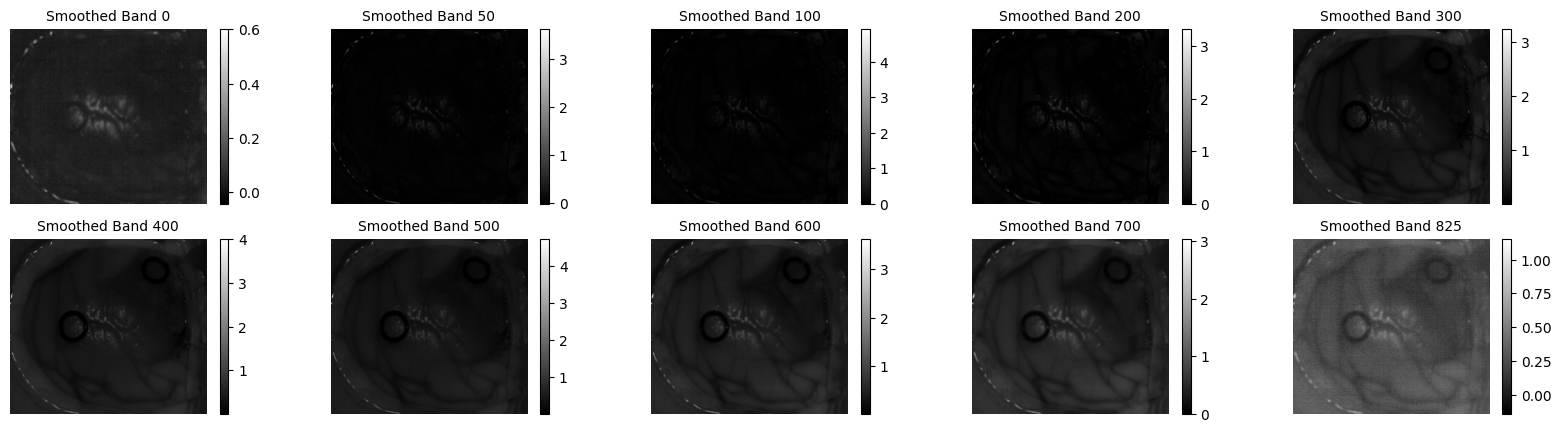

In [ ]:
# Defining the moving average smoothing filter parameters
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
smoothed_cube = np.zeros_like(calibrated_raw)  # initialize an empty array to save the smoothed datacube

# Apply the moving average filter along the spectral dimension for each pixel
for i in range(calibrated_raw.shape[0]):  # Loop over height
  for j in range(calibrated_raw.shape[1]):  # Loop over width
    smoothed_cube[i, j, :] = np.convolve(calibrated_raw[i, j, :], kernel, mode='same') # Convolve the spectral data for each pixel

plt.figure(figsize=(20,5))

for i, band_index in enumerate(band_indices):
    plt.subplot(2, len(band_indices)//2, i+1)
    selected_band = smoothed_cube[:,:,band_index]
    plt.imshow(selected_band, cmap='gray'), plt.title(f"Smoothed Band {band_index}", fontsize=10)
    plt.colorbar()
    plt.axis('off')
    # print(f"Size of band {band_index} is:", selected_band.shape, "minimum value:", np.min(selected_band), "maximum value:", np.max(selected_band))

## The bands at the beginning and at the end of the HSI cubes are discarded.Now the input HSI cube has a new shape, the number of spectral channels reduced from 826 to 645.

In [ ]:
reduced_cube = smoothed_cube[:, :, 55:700]   # the bands before 55th and 700th are discarded to avoid the extreme bands
print("Shape of the reduced cube:", reduced_cube.shape)

Shape of the reduced cube: (443, 497, 645)


## The sampling interval is computed, based on what certain bands would be considered.

In [ ]:
reduced_wavelengths = wavelengths[55:700]   # saving the wavelengths of the bands in reduced_wavelengths variable after band reduction

lambda_max = max(reduced_wavelengths)
lambda_min = min(reduced_wavelengths)

bands_to_consider = 128
sampling_interval = (lambda_max - lambda_min) / bands_to_consider   # a total of 128 bands would be considered based on the sampling interval of the wavelengths
print(f"The minimum wavelength: {lambda_min}, the maximum wavelength: {lambda_max}")
print(f"The sampling interval between {lambda_min} and {lambda_max} is {sampling_interval}")

The minimum wavelength: 440.499, the maximum wavelength: 909.057
The sampling interval between 440.499 and 909.057 is 3.660609375


## Total 128 bands were selected from the reduced shape of the HSI cube, based on the sampling interval.

The 128 selected bands indices: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 242, 247, 252, 257, 262, 267, 272, 277, 282, 287, 292, 297, 302, 307, 312, 317, 322, 327, 332, 337, 342, 347, 352, 357, 362, 367, 372, 377, 382, 387, 392, 397, 402, 408, 413, 418, 423, 428, 433, 438, 443, 448, 453, 458, 463, 468, 473, 478, 483, 488, 493, 498, 503, 508, 513, 518, 523, 528, 533, 538, 543, 548, 553, 558, 564, 569, 574, 579, 584, 589, 594, 599, 604, 609, 614, 619, 624, 629, 634, 639]
The 128 wavelengths: [444.159609375, 447.82021875, 451.48082812499996, 455.14143749999994, 458.8020468749999, 462.4626562499999, 466.1232656249999, 469.78387499999985, 473.44448437499983, 477.1050937499998, 480.7657031249998, 484.42631249999977, 488.08692187499975, 491.7475312499997, 495.4081406249997, 499.0687499999997, 502.72935937499966, 506.38

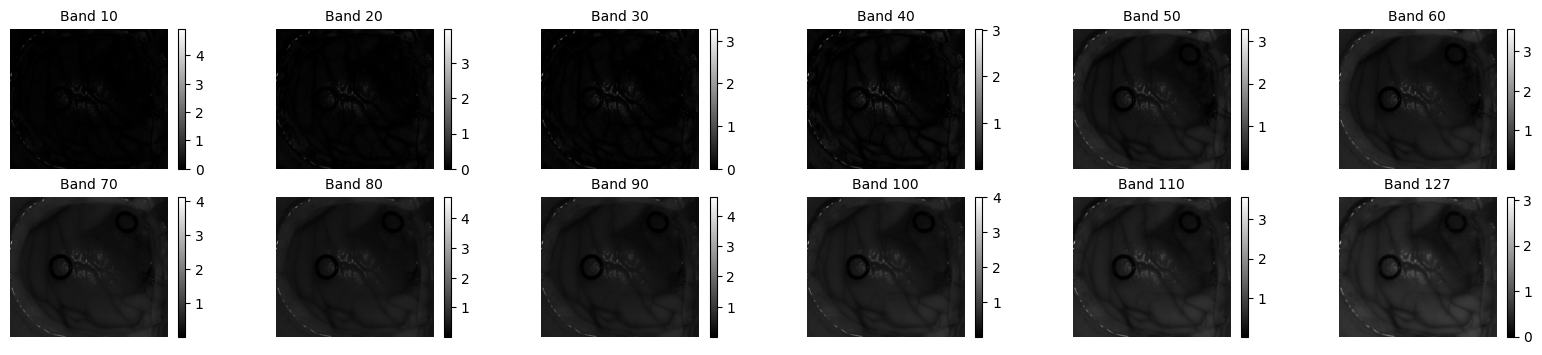

In [ ]:
import random

selected_bands_indices = []
current_wavelength = lambda_min
wavelengths_list = []

# find indices of wavelengths closest to the desired sampling points
for _ in range(bands_to_consider):
  closest_index = np.argmin(np.abs(np.array(reduced_wavelengths)-current_wavelength)) # closest indices would be considered if indices have floating point values
  selected_bands_indices.append(closest_index)
  current_wavelength += sampling_interval
  wavelengths_list.append(current_wavelength)

print("The 128 selected bands indices:", selected_bands_indices)
print("The 128 wavelengths:", wavelengths_list)

# get the selected 128 bands from the reduced cube
selected_cube = reduced_cube[:, :, selected_bands_indices]
print("Shape of the selected cube:", selected_cube.shape)

new_band_indices = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 127]

plt.figure(figsize=(20,4))

for index, band_number in enumerate(new_band_indices):
  plt.subplot(2, len(new_band_indices)//2,index+1)
  individual_band = selected_cube[:, :, band_number]
  plt.imshow(individual_band, cmap='gray'), plt.title(f"Band {band_number}", fontsize=10)
  plt.colorbar()
  plt.axis('off')
  # print(f"Size of band {band_number} is:", individual_band.shape, "minimum value:", np.min(individual_band), "maximum value:", np.max(individual_band))

# Finally, min-max normalization is performed for each pixel along the spectral dimension. Through visual inspection, it is clear that certain image features such as blood vessels, ring are much more visible than the earlier steps.

(443, 497, 128)


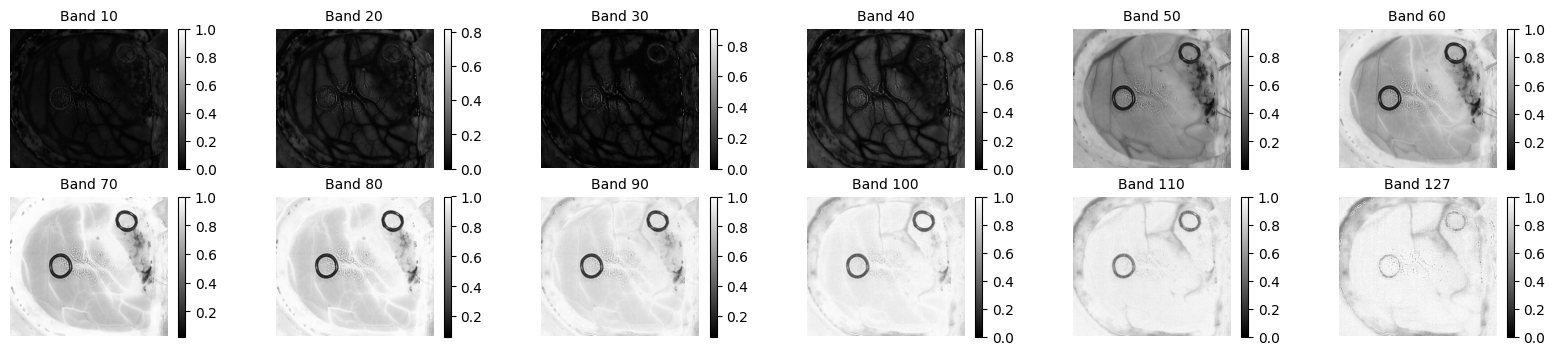

In [ ]:
# Normalization
normalized_cube = np.zeros_like(selected_cube) # initializing an empty array to store the cube

for i in range(selected_cube.shape[0]):
  for j in range(selected_cube.shape[1]):
    spectral_signature = selected_cube[i, j, :]
    min_value = np.min(spectral_signature)
    max_value = np.max(spectral_signature)

    if max_value > min_value: # Avoid division by zero
      normalized_cube[i, j, :] = (spectral_signature - min_value) / (max_value - min_value)
    else:
      normalized_cube[i, j, :] = 0.0

print(normalized_cube.shape)

plt.figure(figsize=(20,4))

for index, band_number in enumerate(new_band_indices):
  plt.subplot(2, len(new_band_indices)//2,index+1)
  individual_band = normalized_cube[:, :, band_number]
  plt.imshow(individual_band, cmap='gray'), plt.title(f"Band {band_number}", fontsize=10)
  plt.colorbar()
  plt.axis('off')
  # print(f"Size of band {band_number} is:", individual_band.shape, "minimum value:", np.min(individual_band), "maximum value:", np.max(individual_band))

## Now, the 128 bands can be saved in .npy file

In [ ]:
output_dir = "" # put your output directory path
npy_file_path = os.path.join(output_dir, '012_01_128_bands.npy')
np.save(npy_file_path, normalized_cube)